# **Time Series Analysis: Introduction to Cointegration**

The purpose of this notebook is to give the reader with the necessary background needed to undertsand latter notebooks which will go further in complexity.

## **Table of Contents:**



In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import statsmodels.api as sm
import yfinance as yf    

from utility.data_processor_helpers import fetch_data, compute_log_returns, compute_spread
from utility.plot_helpers import plot_normalized_prices, plot_spread, plot_correlograms
from utility.statistics_helpers import adf_test, johansen_test, get_beta_ols, ljung_box_test

pio.renderers.default = "notebook+pdf"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **Case Study: The crack spread**

In this exercise, we analyze securities involved in the well-known “crack spread,” a key concept in energy trading that reflects refinery margins from transforming crude oil into refined petroleum products.

For crude oil, we include both major benchmarks: Brent Crude and West Texas Intermediate (WTI) futures contracts. These benchmarks will serve as proxies for crude oil prices.

On the refined product side, petroleum derivatives typically fall into three main categories: gasoline, heating oil, and jet fuel. In this analysis, we will use Gasoline (RB=F) and Heating Oil (HO=F) front-month futures contracts as proxies for petroleum product prices.

In [17]:
start = "2006-08-01"
end = "2019-08-01" # We will keep data up til 2024-11 for the backtest

tickers = ["BZ=F",     # Brent 
           "CL=F",    # WTI Futures
           "RB=F",   # Gasoline 
           "HO=F"]  # Heating Oil

prices = fetch_data(tickers, start, end)
prices.columns = ["Brent", "WTI", "Gasoline", "Heating Oil"]
prices

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Brent        WTI  Gasoline  Heating Oil
Date                                                                  
2007-07-30 00:00:00+00:00  75.739998  76.830002    2.0856       2.0651
2007-07-31 00:00:00+00:00  77.050003  78.209999    2.1408       2.1000
2007-08-01 00:00:00+00:00  75.349998  76.529999    2.0296       2.0694
2007-08-02 00:00:00+00:00  75.760002  76.860001    2.0362       2.0746
2007-08-03 00:00:00+00:00  74.750000  75.480003    2.0290       2.0340
...                              ...        ...       ...          ...
2019-07-25 00:00:00+00:00  63.389999  56.020000    1.8803       1.9143
2019-07-26 00:00:00+00:00  63.459999  56.200001    1.8744       1.9044
2019-07-29 00:00:00+00:00  63.709999  56.869999    1.8634       1.9106
2019-07-30 00:00:00+00:00  64.720001  58.049999    1.8969       1.9440
2019-07-31 00:00:00+00:00  65.169998  58.580002    1.9020       1.9550

[2967 rows x 4 columns]

## **Random Walk & White Noise**

### **1. White Noise**

A **white noise** process is a second order stationary process which do not show any pattern and is considered a pure random noise where all the observations are iid (idependently and identically distributed). The most common white noise is the Gaussian white noise that we simply abbreviate as white noise. 
Mathematically, it is expressed as:

$$
\epsilon_t \sim \mathcal{N}(0, \sigma^2).
$$

Key properties of a white noise process include:
1. **Zero Mean**: $E(\epsilon_t) = 0$,
2. **Constant Variance**: $\text{Var}(\epsilon_t) = \sigma^2$,
3. **No Autocorrelation**: $\text{Cov}(\epsilon_t, \epsilon_{t-k}) = 0$ for all $k \neq 0$.


### **2. Random Walk**
On the one hand, a **random walk** is a type of non-stationary process in which the value of a time series at time \(t\) depends on its value at \(t-1\), plus a random error term. Mathematically, it can be expressed as:

$$
P_t = P_{t-1} + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma^2),
$$

$$
\text{E}(P_t) = P_0
$$

$$
\text{Cov}(P_t, P_s) = \sigma^2 min\{t, s\}
$$

where:
- $P_t$: The value of the series at time $t$,
- $P_{t-1}$: The value of the series at $t-1$,
- $\epsilon_t$: A white noise error term with mean $0$ and variance $\sigma^2$.

Key properties of a random walk include:
1. **Non-Stationarity**: The series does not have a constant mean or variance.
2. **Variance Growth**: The variance increases linearly with time:
3. **Autocorrelation**: Strong correlation exists between the current value and past values.


In [18]:
plot_normalized_prices(prices, plot_returns=True)

As we can see from the plots above, the normalized prices exhibbits a typical random walk behaviour which is corroborated from the graph bellow when taking the difference we obtain a stationary process which seems to be a white noise process.

Even though the price series exibhit random walk behaviour an econometrics test must be performed in order to reinforce this hypothesis usign a unit root test.
In addition, for the log returns series even though visually it seems that the series are white noises, we must perform a white noise test.

## **Autocorrelation**

A first approach to understand unit root and white noise processes can be made by visualizing the correlograms of the prices and difference prices series obtained earlier.
For that purpose, the correlagrams provide a visual diagnostic of the presence or absence of persistence in a time series. For that, the **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** can be used.

### **Autocorrelation Function**
The **Autocorrelation Function (ACF)** quantifies the correlation between a time series $X_t$ and its lagged values $X_{t-k}$ for different lags $k$:
$$
\text{ACF}(k) = \frac{\sum_{t=1}^{n-k} (X_t - \bar{X})(X_{t+k} - \bar{X})}{\sum_{t=1}^{n} (X_t - \bar{X})^2},
$$
where:
- $X_t$: Value of the series at time $t$,
- $\bar{X}$: Mean of the series,
- $n$: Number of observations,
- $k$: Lag.

The ACF provides insight into the overall correlation structure of the series.

### **Partial Autocorrelation Function**
The **Partial Autocorrelation Function (PACF)**, on the other hand, measures the correlation between $X_t$ and $X_{t-k}$ while controlling for the influence of all intermediate lags $1, 2, \ldots, k-1$. Mathematically, the PACF at lag $k$ can be expressed as:
$$
\text{PACF}(k) = \text{Corr}(X_t, X_{t-k} \mid X_{t-1}, X_{t-2}, \ldots, X_{t-k+1}),
$$
where:
- $\text{Corr}$: Conditional correlation, removing the effect of intermediate lags.

Correlograms of `prices`:

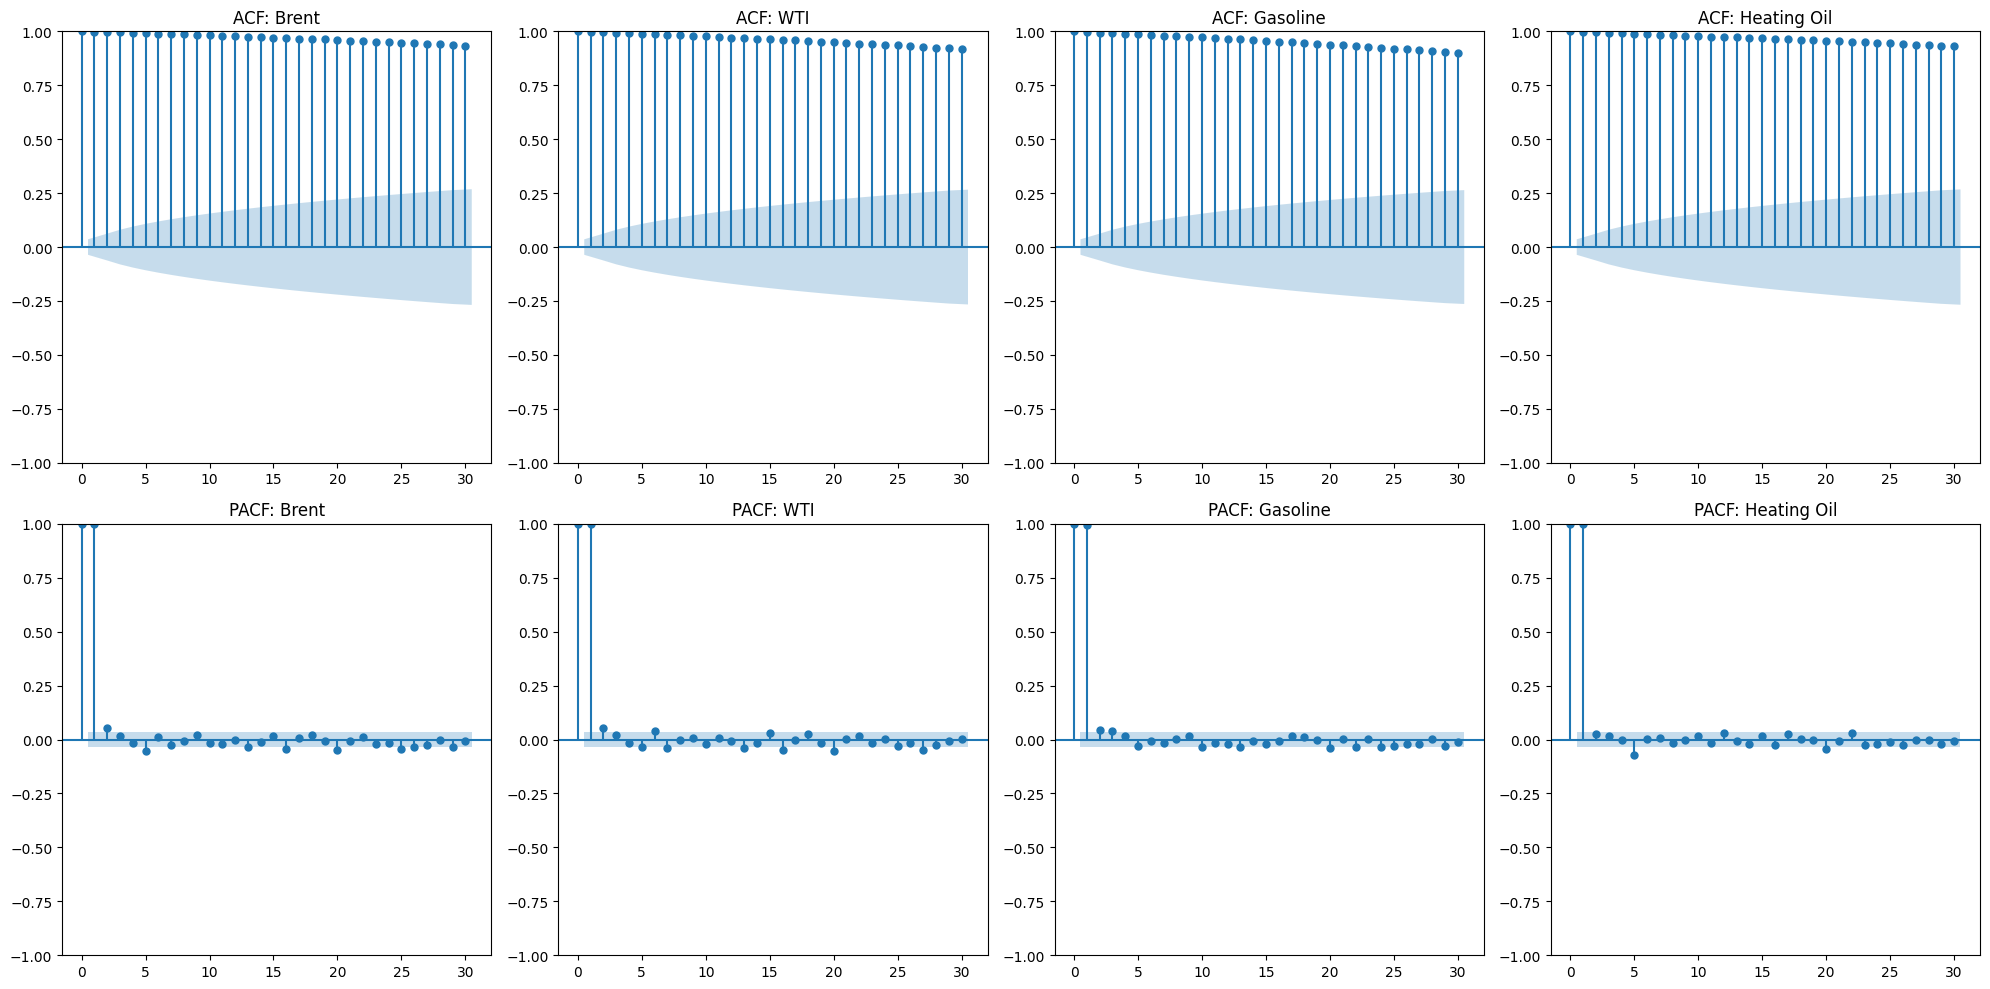

In [20]:
plot_correlograms(prices)

Correlograms of `log_returns`:

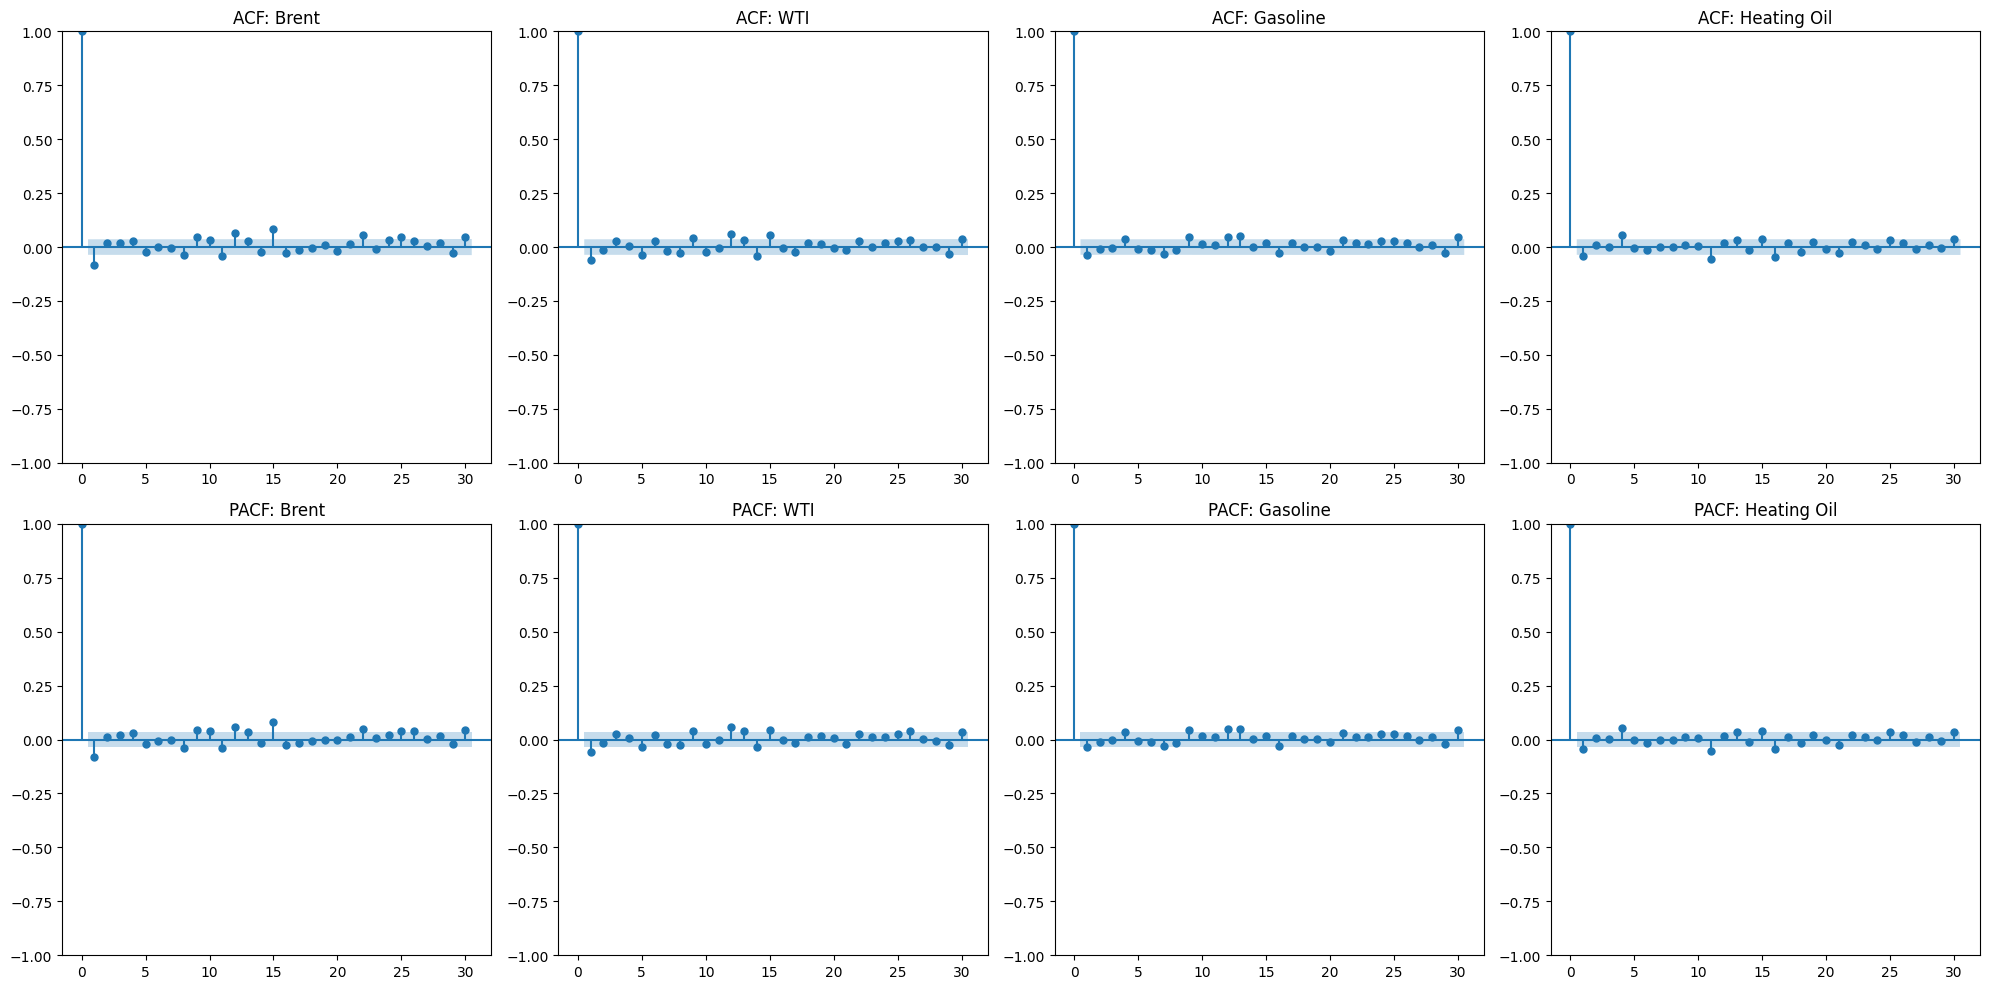

In [21]:
log_returns = prices.apply(compute_log_returns, axis=0)
plot_correlograms(log_returns)

As seen from the correlograms above, the price series show strong persistence in its ACF whereas for the differenced prices no persistence is observed. In both cases, the PACF does not show persistence at all.

## **Unit root and White noise tests**

Now that we have introduced the concepts of correlograms we can introduce the most popular unit root and white noise tests, namely the Augmented Dickey Fuller (ADF) adn Ljung Box test


### **1. Unit Root Test: Augmented Dickey-Fuller (ADF) Test**

The ADF test is one of the most commonly used tests to determine whether a time series contains a **unit root**, which indicates non-stationarity.
The null hypothesis $H_0$ for the ADF test is that the time series has a unit root, i.e., it is non-stationary whereas the alterative hypothesis $H_1$ is that series does not have any root. 

\begin{aligned}
H_0 &: \gamma = 0 \\
H_1 &: \gamma < 0
\end{aligned}


Note: Rejecting the null hypothesis does not necessariliy mean that the times series is stationary as there are other types of stationarity such as trend or seasonal stationarity.

The ADF test is based on the following regression model:
$$
\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \sum_{i=1}^p \delta_i \Delta y_{t-i} + \epsilon_t,
$$
where:
- $\Delta y_t = y_t - y_{t-1}$ is the first difference of the series,
- $\alpha$: Constant (drift term),
- $\beta t$: Linear trend component,
- $\gamma y_{t-1}$: Term that captures the presence of a unit root $H_0: \gamma = 0$,
- $\sum_{i=1}^p \delta_i \Delta y_{t-i}$: Lags of the differenced series to account for autocorrelation,
- $\epsilon_t$: Error term.

The test statistic for the ADF test is:
$$
ADF = \frac{\hat{\gamma}}{\text{SE}(\hat{\gamma})},
$$
where:
- $\hat{\gamma}$: Estimated value of $\gamma$,
- $\text{SE}(\hat{\gamma})$: Standard error of $\hat{\gamma}$.


The $ADF$ statistic is compared against critical values to determine if the null hypothesis can be rejected. If $ADF < \text{critical value}$, the null hypothesis is rejected, and the series is deemed stationary.

ADF test on `prices`: 

In [22]:
results_adf_1 = adf_test(prices)

ADF Test Results for Brent:
Test Statistic: -2.0755
p-value: 0.2545
Critical Values:
    1%: -3.4326
    5%: -2.8625
    10%: -2.5673

ADF Test Results for WTI:
Test Statistic: -2.0468
p-value: 0.2664
Critical Values:
    1%: -3.4326
    5%: -2.8625
    10%: -2.5673

ADF Test Results for Gasoline:
Test Statistic: -1.9828
p-value: 0.2942
Critical Values:
    1%: -3.4326
    5%: -2.8625
    10%: -2.5673

ADF Test Results for Heating Oil:
Test Statistic: -1.7958
p-value: 0.3826
Critical Values:
    1%: -3.4326
    5%: -2.8625
    10%: -2.5673



ADF test on `log_returns`:

In [23]:
results_adf_2 = adf_test(log_returns)

ADF Test Results for Brent:
Test Statistic: -12.0755
p-value: 0.0000
Critical Values:
    1%: -3.4326
    5%: -2.8625
    10%: -2.5673

ADF Test Results for WTI:
Test Statistic: -12.8755
p-value: 0.0000
Critical Values:
    1%: -3.4326
    5%: -2.8625
    10%: -2.5673

ADF Test Results for Gasoline:
Test Statistic: -13.2803
p-value: 0.0000
Critical Values:
    1%: -3.4326
    5%: -2.8625
    10%: -2.5673

ADF Test Results for Heating Oil:
Test Statistic: -13.4564
p-value: 0.0000
Critical Values:
    1%: -3.4326
    5%: -2.8625
    10%: -2.5673



As we can see, all the p values are larger than 1, 5 or 10% for the standard prices indicating a presence of a unit root.
Meanwhile, for the log returns the p-values all tend to 0, indicating the no presence of a unit root.

### **2. White Noise Test: Ljung-Box Test**

The Ljung-Box test evaluates whether a time series is a **white noise process**. White noise implies no autocorrelation across time lags, a constant mean of zero, and constant variance. The null hypthesis is that the time series not display any autocorrelation up til lag $n$ and the alternative hypthesis being the presence of a meaningful autocorrelation.

$$
\begin{aligned}
H_0 &: \rho_i = 0 \hspace{0.2cm} \forall i = 1, 2, ..., n\\
H_1 &: \rho_k \not= 0 \hspace{0.2cm} \text{for some} \ i \in \{1, 2, ..., n\}
\end{aligned}
$$

The Ljung-Box test statistic is:

$$
Q = n(n+2) \sum_{k=1}^m \frac{\hat{\rho}_k^2}{n-k},
$$

where:
- $n$: Number of observations,
- $m$: Number of lags to test,
- $\hat{\rho}_k$: Sample autocorrelation at lag $k$.

The test statistic $Q$ follows a $\chi^2$ distribution with $m$ degrees of freedom.


Ljung-Box test on `prices`:

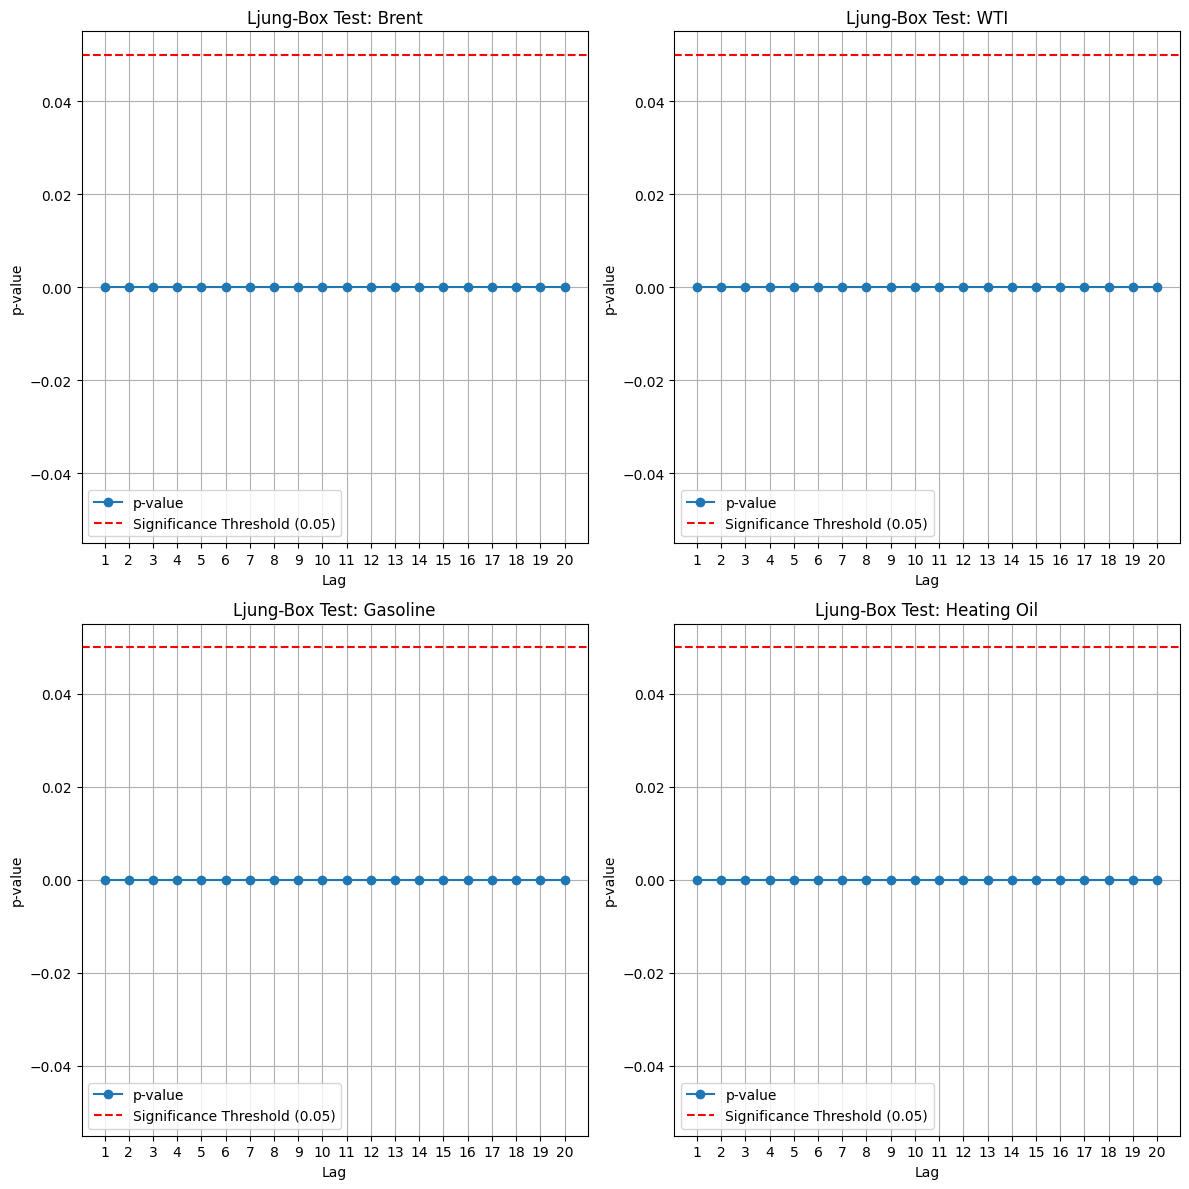

In [25]:
results_ljung_box_1 = ljung_box_test(prices)

Ljung-Box test on `log_returns`:

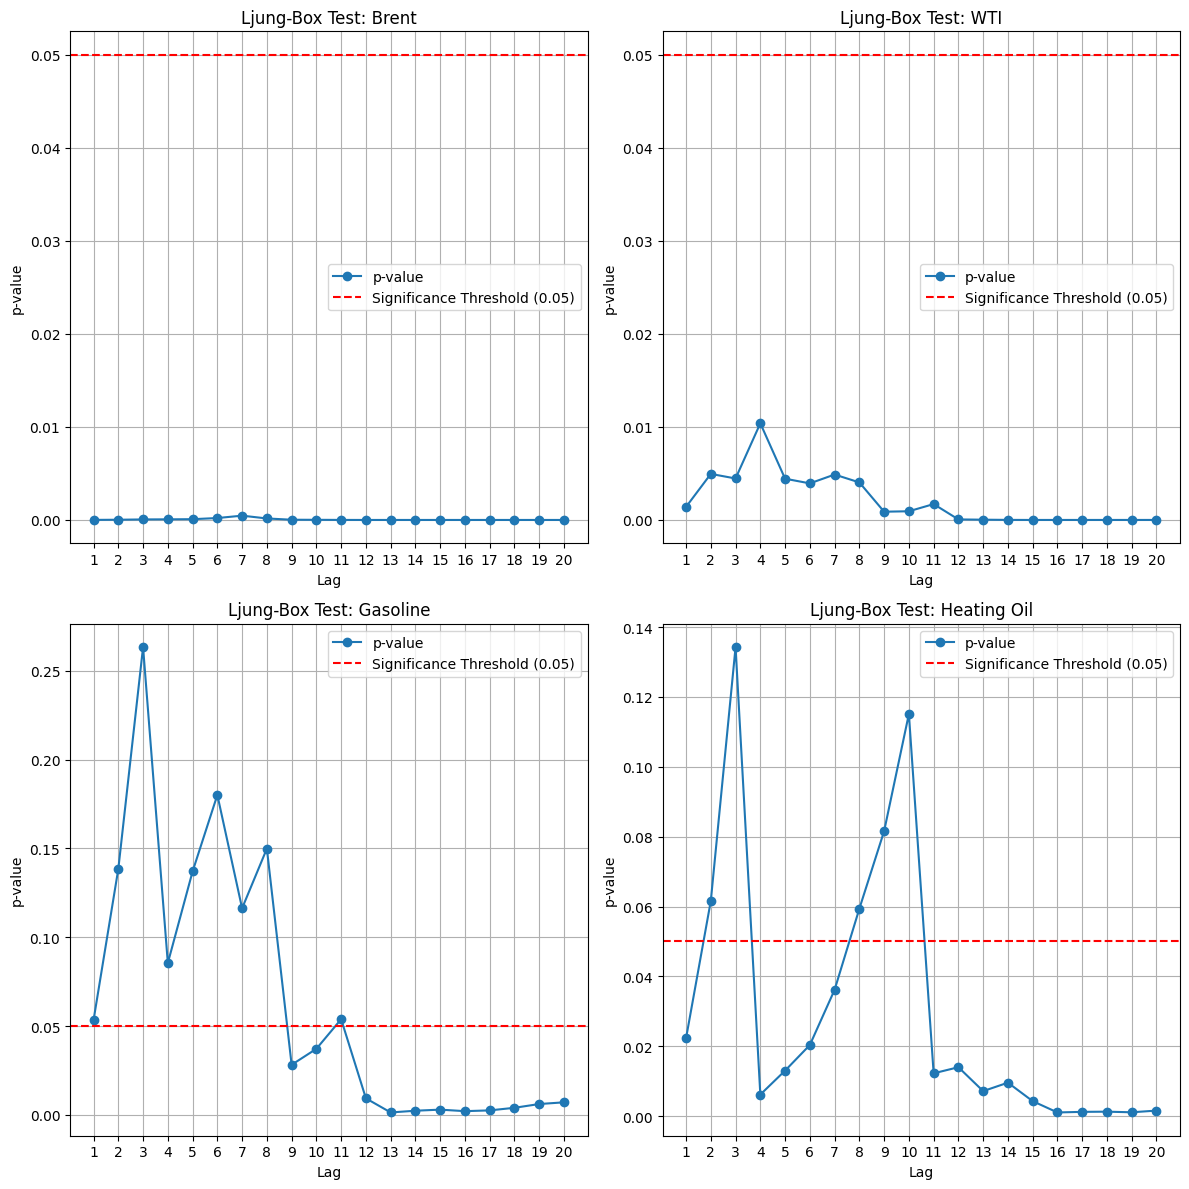

In [26]:
results_ljung_box_2 = ljung_box_test(log_returns)

As seen from the p-values, for the Gasoline and Heating Oil there is a strong presence of autocorrelation when testing for the lags from 1 to 8 and for the lags [2, 3, 8, 9, 10].

However, for both Crude Oil proxies there is no evidence of the presence of autocorrelation.

## **Cointegration**

Cointegration is a statistical property of a group of time series that indicates a long-term equilibrium relationship among them, even though the individual series themselves may be non-stationary.

In the context of financial markets, this concept is used to model the relationship between two or more assets whose prices may deviate temporarily but are expected to revert to a shared equilibrium over time.


### 1. **Case with 2 assets**: $P_A$ and $P_B$

For two assets, $P_A$ and $P_B$, we can define a linear combination, the spread process $S_t$ as:

$$
S_t = P_{A,t} - \hat{\beta} P_{B,t},
$$

where $\hat{\beta}$ is the hedge ratio. If $S_t$ is stationary, then $P_A$ and $P_B$ are said to be **cointegrated**. This implies that the prices may deviate temporarily, but they tend to revert to a long-term equilibrium relationship.

Three natural candidates for pairs of assets emerge in the context of the crack spread.

The first pair is the spread between Brent and WTI, as both serve as benchmarks for crude oil prices and are influenced by similar global factors. However, temporary deviations from their long-term relationship can occur due to regional risk factors, with WTI being U.S.-focused and Brent representing European markets.

For the remaining two pairs, we consider the spreads formed between one of the crude oil benchmarks and the two primary petroleum products derived from it. For consistency, we arbitrarily use Brent as the proxy for crude oil prices in these pairs.

In [27]:
brent_wti = ["Brent", "WTI"]
brent_gasoline = ["Brent", "Gasoline"]
brent_heating_oil = ["Brent", "Heating Oil"]

#### 1.1 **Arbitrary hedge ratio**: $\hat{\beta}=1$

In [28]:
beta_pairs_1 = [1, -1]

plot_spread(prices=prices, tickers=brent_wti, hedge_ratios=beta_pairs_1)
plot_spread(prices=prices, tickers=brent_gasoline, hedge_ratios=beta_pairs_1)
plot_spread(prices=prices, tickers=brent_heating_oil, hedge_ratios=beta_pairs_1)

Brent VS WTI:

In [29]:
spread_brent_wti = compute_spread(prices, brent_wti, beta_pairs_1)
test_brent_wti = adf_test(spread_brent_wti)

ADF Test Results for spread:
Test Statistic: -2.6875
p-value: 0.0762
Critical Values:
    1%: -3.4326
    5%: -2.8625
    10%: -2.5673



Brent VS Gasoline:

In [30]:
spread_brent_gasoline = compute_spread(prices, brent_gasoline, beta_pairs_1)
test_brent_gasoline = adf_test(spread_brent_gasoline)

ADF Test Results for spread:
Test Statistic: -2.0646
p-value: 0.2590
Critical Values:
    1%: -3.4326
    5%: -2.8625
    10%: -2.5673



Brent VS Heating Oil:

In [31]:
spread_brent_heating_oil = compute_spread(prices, brent_heating_oil, beta_pairs_1)
test_brent_heating_oil  = adf_test(spread_brent_heating_oil)

ADF Test Results for spread:
Test Statistic: -2.1330
p-value: 0.2315
Critical Values:
    1%: -3.4326
    5%: -2.8625
    10%: -2.5673



Despite an arbitrary value of 1 for $\hat{\beta}$ the spread between Brent and WTI is relatively stationary whereas for the 2 last cases it is clearly not.
In both cases, we cannot statistically assert at the 5% risk level that any of those pairs are cointegrated.

#### 1.2 **Minimized residuals hedge ratio**: $\hat{\beta}_{OLS}$

##### Engle and Grenger method

To obtain a stationary process from two non-stationary time series, the hedge ratio is computed as the $\beta$ coefficient that best fits the regression line between the two assets.

Once the $\beta$ coefficient is estimated, the residuals of the regression can be calculated. These residuals represent the spread and can then be tested for stationarity using the Augmented Dickey-Fuller (ADF) test.

This procedure is commonly referred to in the literature as the Cointegrated Augmented Dickey-Fuller (CADF) test or the Engle and Granger method.

In [32]:
beta_ols_brent_wti = get_beta_ols(prices, brent_wti)
beta_ols_brent_gasoline= get_beta_ols(prices, brent_gasoline)
beta_ols_brent_heating_oil = get_beta_ols(prices, brent_heating_oil)

print("Beta Brent vs WTI:", beta_ols_brent_wti)
print("Beta Brent vs Gasoline:", beta_ols_brent_gasoline)
print("Beta Brent vs Heating Oil:", beta_ols_brent_heating_oil)

Beta Brent vs WTI: 1.073627316696999
Beta Brent vs Gasoline: 40.9922354602633
Beta Brent vs Heating Oil: 39.051605938845455


In [33]:
beta_pairs_brent_wti = [1, -beta_ols_brent_wti]
beta_pairs_brent_gasoline = [1, -beta_ols_brent_gasoline]
beta_pairs_brent_heating_oil = [1, -beta_ols_brent_heating_oil]

plot_spread(prices=prices, tickers=brent_wti, hedge_ratios=beta_pairs_brent_wti)
plot_spread(prices=prices, tickers=brent_gasoline, hedge_ratios=beta_pairs_brent_gasoline)
plot_spread(prices=prices, tickers=brent_heating_oil, hedge_ratios=beta_pairs_brent_heating_oil)

Brent VS WTI:

In [34]:
spread_brent_wti_ols = compute_spread(prices, brent_wti, beta_pairs_brent_wti)
test_brent_wti_ols = adf_test(spread_brent_wti_ols)

ADF Test Results for spread:
Test Statistic: -2.9375
p-value: 0.0412
Critical Values:
    1%: -3.4326
    5%: -2.8625
    10%: -2.5673



Brent VS Gasoline:

In [35]:
spread_brent_gasoline_ols = compute_spread(prices, brent_gasoline, beta_pairs_brent_gasoline)
test_brent_gasoline_ols = adf_test(spread_brent_gasoline_ols)

ADF Test Results for spread:
Test Statistic: -4.9145
p-value: 0.0000
Critical Values:
    1%: -3.4326
    5%: -2.8625
    10%: -2.5673



Brent VS Heating Oil:

In [36]:
spread_brent_heating_oil_ols = compute_spread(prices, brent_gasoline, beta_pairs_brent_heating_oil)
test_brent_heating_oil_ols = adf_test(spread_brent_heating_oil_ols)

ADF Test Results for spread:
Test Statistic: -4.2702
p-value: 0.0005
Critical Values:
    1%: -3.4326
    5%: -2.8625
    10%: -2.5673



For the Brent vs. WTI pair, we obtain a slightly more stationary process, with the estimated $\hat{\beta}$ from OLS being 1.07 and a p-value below 5%, indicating statistical significance.

For the Brent vs. Gasoline and Brent vs. Heating Oil pairs, the p-values are nearly zero, suggesting that these processes exhibit strong stationarity.

### 2. **Case with N assets**: $P_1$, $P_B$, ..., $P_N$

For $N$ assets, $P_1, P_B, \dots, P_N$, the spread process $S_t$ is defined as a linear combination of their prices:

$$
S_t = \mathbf{P}_t \cdot \mathbf{\hat{\beta}}
$$

where:
- $\mathbf{P}_t = [P_{1,t}, P_{2,t}, \dots, P_{N,t}]$: The **price vector** at time \(t\), representing the prices of \(N\) assets.
- $\mathbf{\hat{\beta}} = [\hat{\beta}_1, \hat{\beta}_2, \dots, \hat{\beta}_N]$: The **hedge ratio vector**, representing the weights assigned to each asset in the spread.

\
If $S_t$ is **stationary**, the assets $P_1, P_2, \dots, P_N$ are said to be **cointegrated**.

Since all pairs are mutually cointegrated, we are going to form a spread consisting Brent, WTI, Gasoline and Hoting Oil

In [37]:
assets = prices.columns

#### **2.1 Arbitrary hedge ratios**: $\mathbf{\hat{\beta}} = [1, 1, \dots, 1]$

In [38]:
beta_basket_1 = [1] + [-1] * (len(assets) -1)
plot_spread(prices=prices, tickers=assets, hedge_ratios=beta_basket_1)

In [39]:
spread_basket_1 = compute_spread(prices, assets, beta_basket_1)
test_basket_1 = adf_test(spread_basket_1)

ADF Test Results for spread:
Test Statistic: -2.8885
p-value: 0.0467
Critical Values:
    1%: -3.4326
    5%: -2.8625
    10%: -2.5673



Despite the choice of arbitrary hedge ratios we obtain a spread which is stationary at the 5% risk level.
Nevertheless, a better spread can be formed using a procedure specific to a basket of assets.

#### 2.3. **Multivariate Cointegration Test**: Johansen Procedure

The Johansen procedure is a statistical test used to identify and estimate cointegration relationships among multiple non-stationary time series. Unlike the Engle-Granger method, which is limited to pairs of assets, the Johansen procedure is well-suited for **multivariate settings**, involving $N$ assets.


##### 2.3.1. **Vector Error Correction Model (VECM)** 
The first step of this procedure consists in expressing the VECM on the price series as follows:


$$
\Delta \mathbf{P}_t = \mathbf{\Pi} \mathbf{P}_{t-1} + \sum_{i=1}^{p-1} \mathbf{\Gamma}_i \Delta \mathbf{P}_{t-i} + \mathbf{\epsilon}_t
$$

where:
- $\mathbf{P}_t$: The price vector at time $t$,
- $\Delta \mathbf{P}_t = \mathbf{P}_t - \mathbf{P}_{t-1}$: First differences of the price series,
- $\mathbf{\Gamma}_i$: Short-term adjustment coefficients,
- $\mathbf{\Pi}$: Long-term equilibrium matrix,
- $\mathbf{\epsilon}_t$: Residual errors.

The purpose of this VECM representation is to capture both short term and long terms relationhips in the price series which are contained in the $\mathbf{\Gamma}_i$'s and $\mathbf{\Pi}$ matrices respectively.


##### 2.3.2. **Singular Value Decomposition (SVD) on $\mathbf{\Pi}$** 

The Johansen procedure uses the **Singular Value Decomposition (SVD)** to decompose the long-term equilibrium matrix $\mathbf{\Pi}$ in order to identify cointegrating relationships. The decomposition provides insight into the number of independent cointegrating vectors among the $N$ assets.

The decomposition of $\mathbf{\Pi}$ is as follows:

$$
\mathbf{\Pi} = \mathbf{\alpha} \mathbf{\beta}^\top
$$

where:
- $\mathbf{\alpha}$: Matrix of **adjustment coefficients** that represent how each time series corrects deviations from the long-term equilibrium.
- $\mathbf{\beta}$: Matrix of **cointegrating vectors**, representing the linear combinations of prices that form stationary spreads.

The rank of $\mathbf{\Pi}$ determines the number of cointegrating relationships:
- If $\text{rank}(\mathbf{\Pi}) = 0$, there are no cointegrating relationships (i.e., the assets are not cointegrated).
- If $0 < \text{rank}(\mathbf{\Pi}) < N$, there are $\text{rank}(\mathbf{\Pi})$ cointegrating relationships.

##### 2.3.3. **Testing for Cointegration**

The Johansen procedure provides two test statistics to determine the rank of $\mathbf{\Pi}$, which corresponds to the number of cointegrating relationships:

1. **Trace Statistic**:
   $$
   \text{Trace Statistic} = -T \sum_{i=r+1}^N \ln(1 - \lambda_i)
   $$
   - Tests the null hypothesis that the number of cointegrating relationships is at most $r$.
   - Sequentially tests for increasing values of $r$, starting from $r = 0$.

2. **Maximum Eigenvalue Statistic**:
   $$
   \text{Max Eigenvalue Statistic} = -T \ln(1 - \lambda_{r+1})
   $$
   - Tests the null hypothesis that the number of cointegrating relationships is equal to $r$, against the alternative of $r+1$.

In these equations:
- $T$: Number of observations,
- $\lambda_i$: Eigenvalues derived from the decomposition of $\mathbf{\Pi}$.

\

Among the two, the trace test is the most popular one as it can be used to determine the total number of cointegration relationships, basically the number of linear combinations that make the spread stationary. 
In fact, works iteratively by testing the null hypothesis for $r = 0, 1, \dots, n-1$. If the null hypothesis is rejected for $r < k$, we accept that the number of cointegration relationships is $r = k-1$. If the null hypothesis is rejected for all $r$ up to $r = n-1$, we conclude that the optimal number of cointegrating pairs is $n$.

##### 2.3.4. **Hedge Ratios and the Spread**

Once the rank of $\mathbf{\Pi}$ is determined, the eigenvectors corresponding to the largest eigenvalues are used to form the cointegrating vectors $\mathbf{\beta}$. These vectors provide the hedge ratios that can be applied to compute the stationary spread:

$$
S_t = \mathbf{P}_t \cdot \mathbf{\hat{\beta}}
$$

In [40]:
trace_results, max_eigen_results, beta = johansen_test(prices, assets)
beta

array([ 0.2948028 , -0.02876241, -7.01441472, -4.33610794])

In [41]:
trace_results

Hypothesis (r)  Trace Statistic  Critical Value (5%)  Reject H0?
0          r ≤ 0        89.088037              47.8545        True
1          r ≤ 1        48.383709              29.7961        True
2          r ≤ 2        16.163734              15.4943        True
3          r ≤ 3         3.032117               3.8415       False

In [42]:
max_eigen_results

Hypothesis (r)  Max Eigenvalue Statistic  Critical Value (5%)  Reject H0?
0          r = 0                 40.704328              27.5858        True
1          r = 1                 32.219975              21.1314        True
2          r = 2                 13.131616              14.2639       False
3          r = 3                  3.032117               3.8415       False

In both tests, there is strong evidence against the hypothesis of no cointegration relationships, indicating that at least one linear combination of the assets exists that makes the spread stationary.

The Trace test rejects the null hypothesis $H_0: r \leq 2$ but does not reject $H_0: r \leq 3$, suggesting that the optimal number of cointegration relationships is 3.

In contrast, the Max Eigenvalue test fails to reject $H_0: r = 2$ and $H_0: r = 3$, indicating that only one cointegration relationship has been identified.

In [43]:
plot_spread(prices, assets, beta)

As a final validation, we perform an ADF test on the spread.

In [44]:
spread_basket = compute_spread(prices, assets, beta)
adf_test(spread_basket)

ADF Test Results for spread:
Test Statistic: -4.9118
p-value: 0.0000
Critical Values:
    1%: -3.4326
    5%: -2.8625
    10%: -2.5673



{'spread': {'Test Statistic': -4.91179633407095,
  'p-value': 3.3076671934822093e-05,
  'Critical Values': {'1%': -3.432562638221284,
   '5%': -2.86251759835993,
   '10%': -2.567290402173133}}}